In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import LSQUnivariateSpline as lspline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import os

#import scikit-misc
from  plotnine import *

In [2]:
df_used_cars=pd.read_csv("/Users/juhi/Downloads/Backup/Stats book/data/used-cars_2cities_prep_py.csv")
df_used_cars.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928524,0,0,0,0


In [4]:

data=df_used_cars
# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [5]:

# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])

In [6]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [7]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]

In [8]:

# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
type,,,
Missing,227,46.804,46.804
SUV,1,0.206,47.010
convertible,6,1.237,48.247
coupe,20,4.124,52.371
pickup,1,0.206,52.577
sedan,229,47.216,99.793
wagon,1,0.206,99.999


In [9]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [10]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2

In [13]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()

,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,12.239175,12.702732,0.204124,0.063918,0.103093,0.098969,0.268041,0.216495,0.123711
std,5.785108,5.294679,0.403476,0.244859,0.304394,0.298929,0.443397,0.412281,0.329592
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,8.430400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.000000,16.450363,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,31.950000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


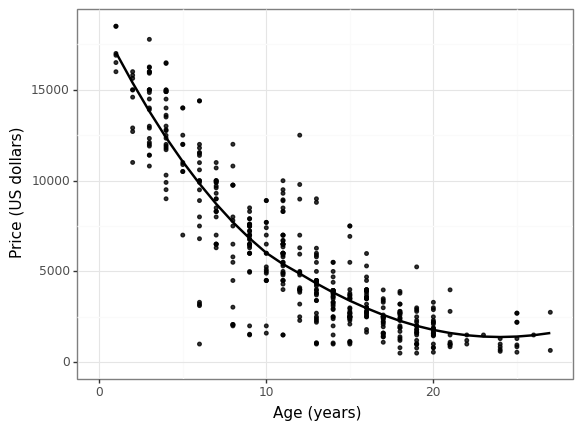

<ggplot: (672308565)>

In [14]:
(
    ggplot(data, aes(x="age", y="price"))
    + geom_point( size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="loess", se=False, size=1, span=0.9)
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
   # + scale_y_continuous(
      #  expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 5000)
    
   # + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5))
)

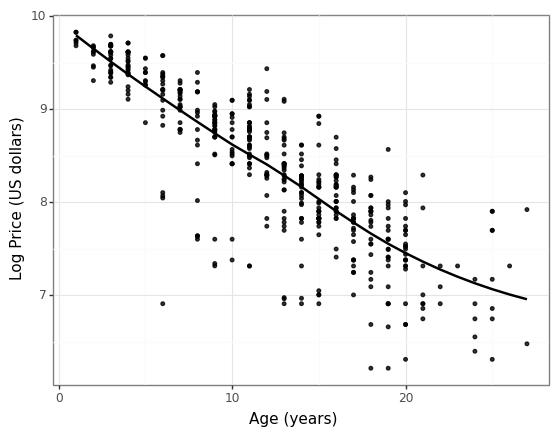

<ggplot: (672950423)>

In [15]:
(
    ggplot(data, aes(x="age", y="lnprice"))
    + geom_point( size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="loess", se=False, size=1, span=0.9)
    + labs(x="Age (years)", y="Log Price (US dollars)")
    + theme_bw()
    #+ expand_limits(x=0.01, y=0.01)
   # + scale_y_continuous(
      #  expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 5000)
    
   # + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5))
)

In [16]:

# Linear regressions

# Model 1: Linear regression on age
model1 = "price ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [17]:
regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

Stargazer(regs[:4])


Cross-validate models


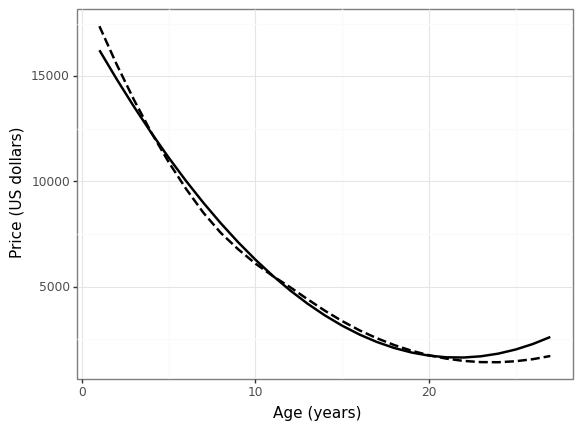

<ggplot: (689867948)>

In [36]:

(
    ggplot(data, aes(x="age"))
    + geom_smooth(
        aes(y="price"),
        #colour=color[0],
        linetype="dashed",
        method="loess",
        se=False,
        size=1,
    )
    + geom_line(aes(y="regs[0].predict()"),  size=1)
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw())
    #+ scale_x_continuous(limits=(0, 30), breaks=seq(0, 30, 5))
    #+ scale_y_continuous(limits=(0, 20000), breaks=seq(0, 20000, 5000))

In [18]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold


In [19]:
def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator
    Estimates `formula` equation with OLS and returns values of 
    , R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.
    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.
    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


In [20]:
regs

In [21]:
model_equations

['price ~ age + agesq',
 'price ~ age + agesq + odometer',
 'price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer',
 'price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer',
 'price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age']

In [22]:
scoring=['neg_root_mean_squared_error','r2']

In [23]:
len(model_equations),len(regs)

(5, 5)

In [24]:


import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse

In [28]:

n_fold=4
cv_list = []
for equation in model_equations:
    cv_list.append(ols_crossvalidator(equation, data, n_fold, average_rmse=False))

In [29]:
(
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        RMSE=lambda x: x["RMSE"].astype(int),
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_equations))],
        Nvars=[1, 2, 5, 6, 6],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.82,1856,8695
Model 2,2,4,0.86,1635,8578
Model 3,5,9,0.88,1500,8526
Model 4,6,13,0.88,1493,8546
Model 5,6,22,0.88,1466,8584


In [30]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,1830,1496,1363,1367,1451
Fold2,1960,1613,1443,1443,1432
Fold3,1863,1769,1670,1670,1677
Fold4,1968,1857,1691,1750,1834
Average,1905,1684,1542,1557,1598


In [46]:



def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,   
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }




def format_confidence_interval(conf_int, round_n=2) :
    """Format confidence interval.

        Parameters
    ----------
    conf_int: np.array
        Array, consisting upper and upper confidence interval values.
    round_n: int, default=2
        Decimals to round floats in output.
    """
    if len(conf_int) != 2:
        raise ConfintError
    elif round_n == 0:
        return "[" + "–".join([str(int(round(i, round_n))) for i in conf_int]) + "]"
    else:
        return "[" + "–".join([str(round(i, round_n)) for i in conf_int]) + "]"


In [47]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [55]:

p95 = pd.DataFrame(
    [
        point_predict_with_conf_int(regs[0], new, interval_precision=0.95, round_n=0),
        point_predict_with_conf_int(regs[2], new, interval_precision=0.95, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p95.loc["Prediction Interval (95%)", :] = p95.loc["Prediction Interval (95%)", :].apply(
    format_confidence_interval
)

In [56]:

p80 = pd.DataFrame(
    [
        point_predict_with_conf_int(regs[0], new, interval_precision=0.80, round_n=0),
        point_predict_with_conf_int(regs[2], new, interval_precision=0.8, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p80.loc["Prediction Interval (80%)", :] = p80.loc["Prediction Interval (80%)", :].apply(
    format_confidence_interval
)

In [57]:
p80.append(p95.loc["Prediction Interval (95%)"])


/var/folders/ww/58ygc81j5kjdkw83ndzzs7200000gn/T/ipykernel_61214/2372009790.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Model 1,Model 2
Point prediction,6277,5868
Prediction Interval (80%),[3886–8668],[3913–7823]
Prediction Interval (95%),[2620–9934],[2878–8858]
